In [2]:
import keras, string, itertools, random, datetime, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from string import punctuation
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.layers import Embedding, Conv1D, Flatten, Dense, Dropout, MaxPool1D, LSTM, \
Bidirectional, TimeDistributed, Dropout
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [3]:
# Define custom functions
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    Description: Prints and plots the confusion matrix.	Normalization can be applied by setting `normalize=True`

    Args:
    - cm: Confusion Matrix
    - classes: Names of classes
    - normalize: Whether to or to not normal values in Confusion Matrix
    - cmap: Plot color
    '''

    # Check if normalize is true or false
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Format axis and plot Confusion Matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

def chunk_seq(words, chunk_len):
    '''
    Description: Creates a sequence of words of length equals to chunk_len

    Args:
    - words: Words in dataset
    - chunk_len: Breaks sequence into provided length
    
    Returns:
        Chunked dataset
    '''
    
    chunked_seq = []
    for i in range(0, len(words), chunk_len):
        chunked_seq.append(words[i:i+chunk_len])
    return chunked_seq

def get_labels(seq):
    '''
    Description: Creates a sequence of labels based on the input sequence

    Args:
    - seq: Input sequence
    
    Returns:
        Sequence labels
    '''
    
    labels_seq = []
    seq = seq.split()
    for i in range(len(seq)):
        if ',' in seq[i]:
            labels_seq.append('<comma>')
        elif '.' in seq[i]:
            labels_seq.append('<period>')
        elif '?' in seq[i]:
            labels_seq.append('<question>')
        elif '!' in seq[i]:
            labels_seq.append('<exclaim>')
        else:
            labels_seq.append('<na>')
    return labels_seq

In [4]:
# Set model parameters
name_1 = 'lstm'
name_2 = 'cnn-lstm'
model_name = name_2
max_seq_len = 128
drop_prob = 0.2
no_filters_1 = 32
no_filters_2 = 64
no_filters_3 = 32
kernel_1 = 3
kernel_2 = 5
kernel_3 = 7
lstm_hidden = 100
embed_dim = 300
adam_lr = 0.001
batch_size = 128
epochs = 10
valid_split = 0.3

In [5]:
# Set misc parameters
current = datetime.datetime.now()
date = current.strftime('%b-%d')
tensor_b = TensorBoard(log_dir='./tf_logs/model_{}_hidden_{}_dropout_{}_embed_dim_{}_lr_{}'.format(model_name, 
                        lstm_hidden, drop_prob,
                        embed_dim, adam_lr), 
                        batch_size=batch_size, 
                        write_graph=True, histogram_freq=0)
early_s = EarlyStopping(monitor='val_loss')
class_names = ['Pad', 'NA', 'Comma', 'Period', 'Question', 'Exclaim']

# Look-up table to remove punctuations from data
table = str.maketrans('', '', punctuation)

# Remove characters
replace = ['—', '-', '♫', '♪', '–', '‘', '…', 'ʾ', '(applause)', '(laughter)']

In [1]:
# Load and process input/label data
# Read and load dataset
data = open('./data/processed/ted_data', 'r', encoding='utf-8').read()

# Convert all characters to lowercase
data = data.lower()

# Remove unnecessary characters
print(Counter(data))
print('\n')
for i in range(len(replace)):
    data = data.replace(replace[i], '')
    
# Group data by sentences into list
data_split = data.split('\n')

# Chain sentences into one 
all_data = ' '.join(data_split)

# Get longest sentence in dataset based on number of words
longest_sent = max(data_split, key=len)
print(longest_sent)
print('\n')
print('Length of longest sentence', len(longest_sent.split()))

# Get all words in the dataset
words = all_data.split()

# Chunk sequence
x = chunk_seq(words, max_seq_len)
sequences = [' '.join(seq) for seq in x]

# Get sequence labels
process_labels = [get_labels(seq) for seq in sequences]
process_labels = [' '.join(seq) for seq in process_labels]

# Remove punctuations
sequences = [seq.translate(table) for seq in sequences]

with open('./processed_input', 'w', encoding='utf-8') as f:
    for x in sequences:
        f.write(x+'\n')

with open('./processed_labels', 'w', encoding='utf-8') as f:
    for x in process_labels:
        f.write(x+'\n')

# Check number of sequences and labels
print('Number of sequences: \t{}'.format(len(sequences)))
print('Number of labels: \t{}'.format(len(process_labels)))

y_labels = open('./processed_labels', 'r', encoding='utf-8').read()
y_labels = y_labels.split('\n')
y_labels = y_labels[:-1]
all_labels = ' '.join(y_labels)
labels_tag = all_labels.split()

split = int(0.8*len(all_labels))
test_y_counts = all_labels[split:]
test_y_counts_split = test_y_counts.split()
counts = Counter(test_y_counts_split)

NameError: name 'Counter' is not defined

In [6]:
# Build words vocab
all_data = ' '.join(sequences)
words = all_data.split()
words_in_vocab = Counter(words)
vocab = sorted(words_in_vocab, key=words_in_vocab.get, reverse=True)

# Skip most common word
vocab_to_int = {word: index for index, word in enumerate(vocab, 2)}
vocab_to_int['-PAD-'] = 0  # The special value used for padding
vocab_to_int['-OOV-'] = 1  # The special value used for OOVs
unique_vocab = len(vocab_to_int)
print('Number of unique words:', unique_vocab)

# Build labels vocab
labels_in_vocab = Counter(labels_tag)
labels_vocab = sorted(labels_in_vocab, key=labels_in_vocab.get, reverse=True)
label_to_int = {t: i for i, t in enumerate(labels_vocab, 1)}
label_to_int['-PAD-'] = 0  # The special value used to padding

# Check labels
no_classes = len(label_to_int)
print('Class distribution:', Counter(labels_in_vocab))
print('Number of unique labels:', no_classes)
print(label_to_int)

Number of unique words: 108807
Class distribution: Counter({'<na>': 4359525, '<comma>': 354651, '<period>': 288658, '<question>': 25867, '<exclaim>': 2202})
Number of unique labels: 6
{'<comma>': 2, '<exclaim>': 5, '<question>': 4, '<na>': 1, '<period>': 3, '-PAD-': 0}


In [7]:
# Tokenize input sequences
seq_int = []
for seq in sequences:
    seq_int.append([vocab_to_int[word] for word in seq.split()])

# Pad input sequences
pad_seq = pad_sequences(sequences=seq_int, maxlen=max_seq_len, padding='post', value=0)

# Check sample sequence
print('Sample sequence:', sequences[-1])
print('\n')
print('Sample sequence:', pad_seq[-1])
print('\n')

# Tokenize output labels
lab_int = []
for lab in y_labels:
    lab_int.append([label_to_int[word] for word in lab.split()])

# Pad input labels
pad_labels = pad_sequences(sequences=lab_int, maxlen=max_seq_len, padding='post', value=0)
encoded_labels = [to_categorical(i, num_classes=no_classes) for i in pad_labels]

# Check sample label
print('Sample label:', pad_labels[-1])
print('\n')
print('Encoded label', encoded_labels[-1])
print('\n')
# Check max seq length
print("Maximum sequence length: {}".format(max_seq_len))
print('\n')

# Check that all sequences and labels are at max sequence length 
assert len(pad_seq)==len(seq_int)
assert len(pad_seq[0])==max_seq_len

assert len(pad_labels)==len(lab_int)
assert len(pad_labels[0])==max_seq_len
print('Sequence and labels length check passed!')

Sample sequence: plans made with the game to actually build the real cityand these videos that i have shown you these are the people who are coming up with new kinds of solutions we know that cities are growing theyre getting bigger as we go and the percentage of population living in cities is projected to rise so we need the solutions and these people playing the game they are trying out different kinds of solutions they might have something that is really important so what we are seeing here is dream cities that might be real one day so it might be that this is not just a game it might be a way to decide our own fatethank youapplause


Sample sequence: [  2820    152     22      2    526      4     84    312      2    232
  14703     47   1817      7      9     19    964     11     47     18
      2     38     69     18    311     61     22    105    482      5
   1136     12     58      7    550     18    662    125    264    831
     30     12     95      3      2   2463      5    

In [8]:
# Split train and label dataset
train_test_split_frac = 0.8
split_index = int(0.8*len(pad_seq))

# Split data into training, validation, and test data (features and labels, x and y)
train_val_x, test_x = pad_seq[:split_index], pad_seq[split_index:]
train_val_y, test_y = encoded_labels[:split_index], encoded_labels[split_index:]

# print out the shapes of your resultant feature data
print('Training/Validation Dataset: \t{}'.format(train_val_x.shape), len(train_val_y))
print('Testing Dataset: \t\t{}'.format(test_x.shape), len(test_y))

Training/Validation Dataset: 	(31443, 128) 31443
Testing Dataset: 		(7861, 128) 7861


In [9]:
# Model code
model = Sequential()
model.add(Embedding(input_dim=unique_vocab, output_dim=embed_dim, input_length=max_seq_len))
model.add(Conv1D(filters=no_filters_1, kernel_size=kernel_1, padding='SAME', strides=1))
model.add(Dropout(rate=drop_prob, seed=50))
model.add(Conv1D(filters=no_filters_2, kernel_size=kernel_2, padding='SAME', strides=1))
model.add(Dropout(rate=drop_prob, seed=50))
model.add(Conv1D(filters=no_filters_3, kernel_size=kernel_3, padding='SAME', strides=1))
model.add(Dropout(rate=drop_prob, seed=50))
model.add(Bidirectional(LSTM(lstm_hidden, return_sequences=True)))
model.add(Dropout(rate=drop_prob, seed=50))
model.add(Bidirectional(LSTM(lstm_hidden, return_sequences=True)))
model.add(Dropout(rate=drop_prob, seed=50))
model.add(TimeDistributed(Dense(no_classes, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer=Adam(adam_lr), 
              metrics=['accuracy'])#, ignore_class_accuracy(0)])
model.summary()
model.fit(x=train_val_x, y=np.array(train_val_y), batch_size=batch_size, 
          epochs=epochs, validation_split=valid_split, steps_per_epoch=None, validation_steps=None,
          shuffle=True, verbose=1, callbacks=[tensor_b, early_s])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 300)          32642100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           28832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 64)           10304     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 64)           0         
__________

In [10]:
test_data = test_x[69]
pred_x_seq = []
for x in test_data:
    for value, index in vocab_to_int.items():
        if x == index:
            pred_x_seq.append(value)

# Predicted output
pred_expand = model.predict(np.expand_dims(test_data, axis=0))
pred_y = []
for y in pred_expand:
    pred_y.append(np.argmax(y, axis=1))
print('Predictions Index:')
print(pred_y)

pred_y_seq = []
for x in pred_y:
    for y in x:
        for value, index in label_to_int.items():
            if y == index:
                pred_y_seq.append(value)

combined = []
for i in range(len(pred_x_seq)):
    if pred_y_seq[i] == '<comma>':
        combined.append(str(pred_x_seq[i])+',')
    elif pred_y_seq[i] == '<period>':
        combined.append(str(pred_x_seq[i])+'.')
    else:
        combined.append(str(pred_x_seq[i]))

for i in range(len(combined)):
    if '.' in combined[i]:
        combined[i+1] = combined[i+1].capitalize()
    if combined[i] == 'i':
        combined[i] = combined[i].capitalize()
    else:
        continue
        
combined = ' '.join(combined)
combined

print('\n')
print('Prediction sequence:')            
print(' '.join(pred_x_seq))
print('\n')
print('Prediction output:')
print(' '.join(pred_y_seq))
print('\n')
print('Combined prediction:')
print(combined)

Predictions Index:
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]


Prediction sequence:
if hed be interested in doing a photography project exploring this questionas and i was interested in the question but i was actually much more interested in staceys motivation for asking it particularly since id never known stacey to have a boyfriend so as part of this project i thought itd be interesting if she tried to meet someone so my idea was to have stacey here go speed dating in las vegas on valentines day laughter applause musicsb we ended up at what was advertised as the worlds largest speed dating event i had 19

Test dataset distribution: Counter({'<na>': 878384, '<comma>': 68084, '<period>': 56541, '<question>': 5258, '<exclaim>': 456, 'mma>': 1})
[[     0      9      0      0      0      0]
 [     0 862207   7018   6864     87      0]
 [     0  39576  16405  11854     63      0]
 [     0  24439   6358  25563     64      0]
 [     0   2782    705   1425    333      0]
 [     0    252     61    142      1      0]]


/home/leo/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.93      0.98      0.96    876176
           2       0.54      0.24      0.33     67898
           3       0.56      0.45      0.50     56424
           4       0.61      0.06      0.11      5245
           5       0.00      0.00      0.00       456

   micro avg       0.90      0.90      0.90   1006208
   macro avg       0.44      0.29      0.32   1006208
weighted avg       0.88      0.90      0.88   1006208

Normalized confusion matrix
[[0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.84056856e-01 8.00980625e-03 7.83404248e-03
  9.92951188e-05 0.00000000e+00]
 [0.00000000e+00 5.82874311e-01 2.41612419e-01 1.74585408e-01
  9.27862382e-04 0.00000000e+00]
 [0.00000000e+00 4.33131292e-01 1.12682546e-01 4.53051893e-01
  1.13426911e-03 0.00000000e+00]
 [0.00000000e+00 5.30409914e-01 1.34413727e-01 2.

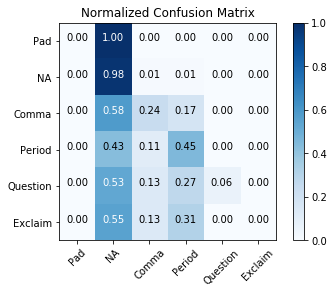

In [11]:
# Create confusion matrix and classification report
for_report = model.predict(test_x)
out_pred = [np.argmax(x, axis=1) for x in for_report]
out_pred = np.concatenate(out_pred, axis=0)

y_ = [np.argmax(x, axis=1) for x in test_y]
y_ = np.concatenate(y_, axis=0)

print('Test dataset distribution:', counts)
cm = confusion_matrix(y_true=y_, y_pred=out_pred)
print(cm)

cr = classification_report(y_true=y_, y_pred=out_pred)
print(cr)

plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()